# Classification of Japanese Characters

For this lab we will be using KMNIST, which is a variation on the MNIST challenge.  This dataset has 10 Japanese characters from the Kuzushiji alphabet as seen below where the clean/standardized version is on the far left and handwritten variations are along the rows.  

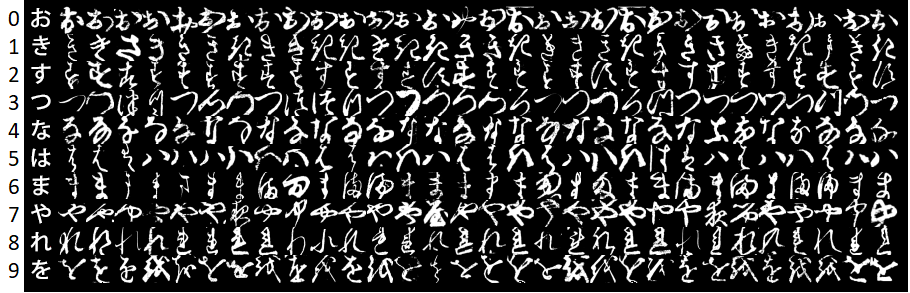

Kuzushiji is basically a cursive way to write Japanese characters, and more common characters actually have more variations than less common characters, which makes them harder to distinguish.  Translations made by experts have been established to take the handwritten characters and map them to modern, standardized versions.  For more, you can read about it here: https://www.tofugu.com/japanese/hentaigana-history-of-japanese-writing-system/

Wouldn't it be nice it this could be automated?  Let's start by loading some libraries...

Please note that this notebook must be run in a "Containerized" Jupyter Notebook on Rosie.  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-02-06 19:28:49.524057: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


## Load and Visualize Data

The data are organized into four files:

* Training images
* Training labels
* Testing images
* Testing labels

These can be loaded with `np.load()`.  This will return a dict-like object with a single key: `arr_0`.  The objects need to be closed when done.

Images are stored as a 3D array: image, rows, columns.

In [2]:
with np.load("/data/cs2300/L8/kmnist-train-imgs.npz") as training_images_fl:
    print(list(training_images_fl.keys()))
    print(training_images_fl["arr_0"].shape)
    training_images = training_images_fl["arr_0"]
    
with np.load("/data/cs2300/L8/kmnist-test-imgs.npz") as testing_images_fl:
    print(list(testing_images_fl.keys()))
    print(testing_images_fl["arr_0"].shape)
    testing_images = testing_images_fl["arr_0"]
    
with np.load("/data/cs2300/L8/kmnist-train-labels.npz") as training_labels_fl:
    print(list(training_labels_fl.keys()))
    print(training_labels_fl["arr_0"].shape)
    training_labels = training_labels_fl["arr_0"]
    
with np.load("/data/cs2300/L8/kmnist-test-labels.npz") as testing_labels_fl:
    print(list(testing_labels_fl.keys()))
    print(testing_labels_fl["arr_0"].shape)
    testing_labels = testing_labels_fl["arr_0"]

['arr_0']
(60000, 28, 28)
['arr_0']
(10000, 28, 28)
['arr_0']
(60000,)
['arr_0']
(10000,)


In [3]:
print(training_images[0])

[[  0   0   0   0   0   0   0   0   0   0   0 118 255 255 124   1   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  36 238 255 146   2   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0  12 203 255 220  14   0   0   0  11
  132  95 187  95   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0 149 255 251  66   0   0   0   7 168
  136  10 223 245  67   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0  51 247 255 156   1   0   0   0 130 201
    9   0 158 255 170   0   0   0   0   0]
 [  0   0   0   0   0   0   0  11 212 255 226  22   0   0   0  79 240  38
    0   0 143 255 197   0   0   0   0   0]
 [  0   0   0   0   0   0   0 148 255 255 107   0   0   0  33 237 121   0
    0   0 144 255 222   0   0   0   0   0]
 [  0   0   0   0   0   0   0 205 255 178   3   0   0   1 179 208   5   0
    0   0 126 255 166   0   0   0   0   0]
 [  0   0   0   0   0   0   7 245 255  76   0   0   0 124 254 10

Let's take a look at some of the characters.  

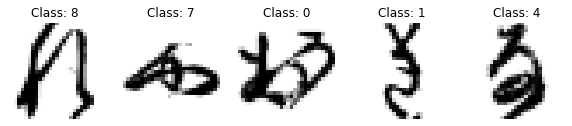

In [4]:
_, axes = plt.subplots(nrows=1, ncols=5, figsize=(10, 10))
for ax, image, label in zip(axes, training_images, training_labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('Class: %i' % label)

## Set up Data for Deep Learning Models

In the following cell, we reshape and prepare the data for training.  The data needs to be in 4D tensors of shape (N,28,28,1) where N is the number of images.  Each image is 28x28 pixels.  Since they are greyscale, the images only have a single channel. 

The tensors represent the 256 possible gray colors using integer values (e.g., 0, 1, 2, …, 255).  You need to convert the tensors to 32-bit floats and divide by 255 to scale the pixels to the range of [0, 1].  You should add the lines of code to do this in the area marked TODO below.

In [5]:
num_classes = 10

# input image dimensions
img_rows, img_cols = 28, 28

x_train = training_images
x_test = testing_images
# Convert class vectors to binary class matrices
y_train = training_labels
y_test = testing_labels

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# TODO
x_train = x_train / 255
y_train = y_train /255

# create the data generator to feed the training with augmentations
datagen = ImageDataGenerator(rotation_range= 1.7 ,zoom_range=0.07)
datagen.fit(x_train)

In the following cell, print out the number of training and test samples using x_train and x_test.  Store these values in variables named train_samples and test_samples (respectively).  

In [6]:
# TODO
print(x_train.shape)
print(x_test.shape)

train_samples = 60000
test_samples = 10000

(60000, 28, 28, 1)
(10000, 28, 28, 1)


## Create the first model

Next we will create a fully connected feed forward neural network (aka. Dense Neural Network (DNN)) model.  You need to add a line of code below to calculate the number of steps per epoch based on the number of training samples and batch size.  

In [7]:
dnn_epochs = 5
dnn_batch_size = 64

# TODO Calculate steps_per_epoch
steps_per_epoch = 60000 / 64




dnn_model = Sequential()
dnn_model.add(Flatten())
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(128, activation='relu'))
dnn_model.add(Dense(num_classes, activation='softmax'))

dnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])

2023-02-06 19:28:51.889763: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-06 19:28:52.471486: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13665 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:da:00.0, compute capability: 7.5


## DNN Training

You should then run the next cell with the current hyperparameters, and then experiment with different epoch numbers, batch sizes, and data augmentation (rotation, zoom) to determine what configuration gives a "good" balance of accuracy and performance.  If you are feeling ambitious, you could experiment with the number of hidden dense layers and optimization functions (https://keras.io/api/optimizers/).  Record all your experiments in a markdown table in the DNN Results table below.  You should run at least 5 different experiments.  

Hints:
- You can determine the model size (total number of parameters) using the .summary() method for each model you create. 
- You can measure the test accuracy using the code below.

After running all your experiments for the DNN, you should create a plot that shows how they trade off performance (training time) vs. test accuracy.

Make a few statements on what you observed about the relationships between the data you captured in the table.  There should be notable correlations.    

Epoch 1/5
937/937 [==============================] - 9s 9ms/step - loss: 1.1386 - accuracy: 0.6807
Epoch 2/5
937/937 [==============================] - 8s 9ms/step - loss: 0.6149 - accuracy: 0.8177
Epoch 3/5
937/937 [==============================] - 8s 9ms/step - loss: 0.5049 - accuracy: 0.8501
Epoch 4/5
937/937 [==============================] - 8s 9ms/step - loss: 0.4400 - accuracy: 0.8670
Epoch 5/5
313/313 [==============================] - 0s 1ms/step
Test Accuracy: 77.67%
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                   

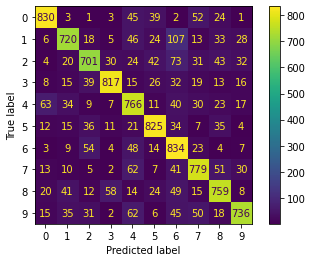

CPU times: user 59.8 s, sys: 5.24 s, total: 1min 5s
Wall time: 43.6 s


In [8]:
%%time
dnn_epochs = 5
history = dnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  steps_per_epoch = steps_per_epoch,
                                  epochs=dnn_epochs)

predicted_probabilities = dnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
acc = 100. * accuracy_score(y_test, predicted_classes)
print("Test Accuracy: {:.2f}%".format(acc))
dnn_model.summary()

cm = confusion_matrix(y_test, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

Epoch 1/15
937/937 [==============================] - 8s 9ms/step - loss: 0.3663 - accuracy: 0.8916
Epoch 2/15
937/937 [==============================] - 9s 9ms/step - loss: 0.3468 - accuracy: 0.8968
Epoch 3/15
937/937 [==============================] - 8s 9ms/step - loss: 0.3306 - accuracy: 0.9011
Epoch 4/15
937/937 [==============================] - 8s 9ms/step - loss: 0.3067 - accuracy: 0.9089
Epoch 5/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2915 - accuracy: 0.9141
Epoch 6/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2737 - accuracy: 0.9182
Epoch 7/15
937/937 [==============================] - 9s 9ms/step - loss: 0.2610 - accuracy: 0.9225
Epoch 8/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2530 - accuracy: 0.9254
Epoch 9/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2390 - accuracy: 0.9295
Epoch 10/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2331 - accuracy: 0.9313

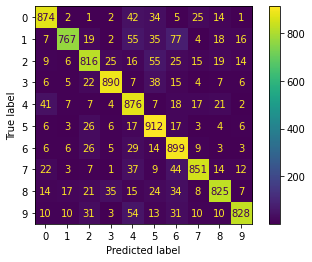

CPU times: user 2min 56s, sys: 13.9 s, total: 3min 10s
Wall time: 2min 7s


In [9]:
%%time
dnn_epochs = 15

history = dnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  steps_per_epoch = steps_per_epoch,
                                  epochs=dnn_epochs)
predicted_probabilities = dnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
acc = 100. * accuracy_score(y_test, predicted_classes)
print("Test Accuracy: {:.2f}%".format(acc))
dnn_model.summary()
cm = confusion_matrix(y_test, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

Epoch 1/5
300/300 [==============================] - 3s 9ms/step - loss: 0.1783 - accuracy: 0.9463
Epoch 2/5
300/300 [==============================] - 3s 9ms/step - loss: 0.1717 - accuracy: 0.9504
Epoch 3/5
300/300 [==============================] - 3s 9ms/step - loss: 0.1612 - accuracy: 0.9507
Epoch 4/5
300/300 [==============================] - 3s 9ms/step - loss: 0.1774 - accuracy: 0.9476
Epoch 5/5
313/313 [==============================] - 0s 1ms/step
Test Accuracy: 85.54%
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                   

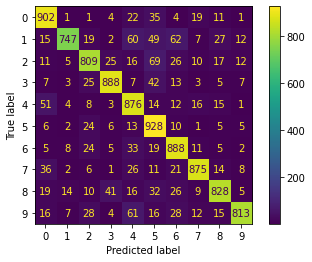

CPU times: user 19.8 s, sys: 1.72 s, total: 21.5 s
Wall time: 14.4 s


In [10]:
%%time
dnn_epochs = 5
dnn_batch_size = 200
steps_per_epoch = 60000 / 200

history = dnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  steps_per_epoch = steps_per_epoch,
                                  epochs=dnn_epochs)
predicted_probabilities = dnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
acc = 100. * accuracy_score(y_test, predicted_classes)
print("Test Accuracy: {:.2f}%".format(acc))
dnn_model.summary()
cm = confusion_matrix(y_test, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

Epoch 1/5
937/937 [==============================] - 8s 9ms/step - loss: 0.1769 - accuracy: 0.9495
Epoch 2/5
937/937 [==============================] - 9s 9ms/step - loss: 0.1620 - accuracy: 0.9531
Epoch 3/5
937/937 [==============================] - 8s 9ms/step - loss: 0.1597 - accuracy: 0.9539
Epoch 4/5
937/937 [==============================] - 8s 9ms/step - loss: 0.1575 - accuracy: 0.9545
Epoch 5/5
313/313 [==============================] - 0s 1ms/step
Test Accuracy: 85.99%
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                   

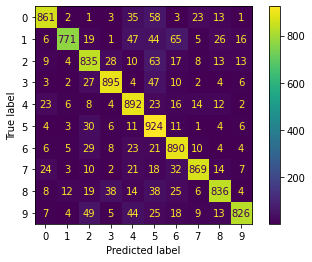

CPU times: user 59.8 s, sys: 5.04 s, total: 1min 4s
Wall time: 43.4 s


In [11]:
%%time
dnn_epochs = 5
dnn_batch_size = 64
steps_per_epoch = 60000 / 64

history = dnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  steps_per_epoch = steps_per_epoch,
                                  epochs=dnn_epochs)
predicted_probabilities = dnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
acc = 100. * accuracy_score(y_test, predicted_classes)
print("Test Accuracy: {:.2f}%".format(acc))
dnn_model.summary()
cm = confusion_matrix(y_test, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

Epoch 1/5
937/937 [==============================] - 8s 9ms/step - loss: 0.1486 - accuracy: 0.9571
Epoch 2/5
937/937 [==============================] - 8s 9ms/step - loss: 0.1374 - accuracy: 0.9598
Epoch 3/5
937/937 [==============================] - 8s 9ms/step - loss: 0.1371 - accuracy: 0.9604
Epoch 4/5
937/937 [==============================] - 8s 9ms/step - loss: 0.1327 - accuracy: 0.9615
Epoch 5/5
313/313 [==============================] - 0s 1ms/step
Test Accuracy: 85.14%
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, None)              0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                   

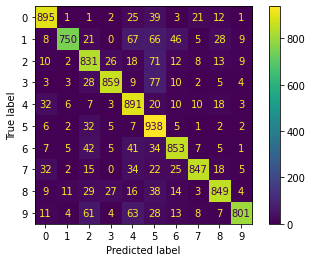

CPU times: user 59.4 s, sys: 4.75 s, total: 1min 4s
Wall time: 43 s


In [12]:
%%time
dnn_epochs = 5
dnn_batch_size = 64
steps_per_epoch = 60000 / 64

history = dnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  steps_per_epoch = steps_per_epoch,
                                  epochs=dnn_epochs)
predicted_probabilities = dnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
acc = 100. * accuracy_score(y_test, predicted_classes)
print("Test Accuracy: {:.2f}%".format(acc))
dnn_model.summary()
cm = confusion_matrix(y_test, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

Epoch 1/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1261 - accuracy: 0.9624
Epoch 2/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1169 - accuracy: 0.9651
Epoch 3/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1352 - accuracy: 0.9606
Epoch 4/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1263 - accuracy: 0.9634
Epoch 5/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1264 - accuracy: 0.9639
Epoch 6/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1171 - accuracy: 0.9636
Epoch 7/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1243 - accuracy: 0.9639
Epoch 8/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1259 - accuracy: 0.9633
Epoch 9/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1183 - accuracy: 0.9678
Epoch 10/15
300/300 [==============================] - 3s 9ms/step - loss: 0.1163 - accuracy: 0.9656

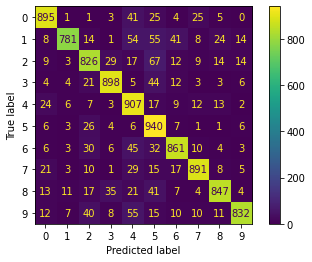

CPU times: user 57.8 s, sys: 4.8 s, total: 1min 2s
Wall time: 42 s


In [13]:
%%time
dnn_epochs = 15
dnn_batch_size = 200
steps_per_epoch = 60000 / 200

history = dnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  steps_per_epoch = steps_per_epoch,
                                  epochs=dnn_epochs)
predicted_probabilities = dnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
acc = 100. * accuracy_score(y_test, predicted_classes)
print("Test Accuracy: {:.2f}%".format(acc))
dnn_model.summary()
cm = confusion_matrix(y_test, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

## DNN Results

| Model Name  | Optimizer | # Params | # Epochs | Batch Size | Rotation | Zoom | Train Acc | Test Acc | Tr. Time w/GPU |
| ----------- | --------- | -------- | -------- | ---------- | -------- | ---- |--------- | -------- | -------------- |
| Default     | SGD       | 118,282      | 5        | 64         | 1       | 0.01  | 97.25       | 86.22      | 0:43            
| +10 Epochs | SGD | 118,282 | 15 | 64 |1| 0.01 | 99.23 | 86.43 | 2:10 |
| 200 batch| SGD | 118,282 | 5 | 200 | 1 | 0.01 | 99.85 | 87.27 | 0:14 |
| Rotation/10| SGD | 118,282 | 5 | 64 | .1 | 0.01 | 88.69 | 77.80 | 0:43 |
|Rotation x2 | SDG | 118,282 | 5 | 64 | 2 | .01 | 88.00 | 77.50| 0:43 |
|+Batch +Epoch | SDG | 118,282 | 15 | 200 | 1 | .01 | 97.66 | 85.28 | 0:41 |

## Accuracy
In the next cell, we calculate the accuracy of the model against an unseen set of data "test".  Remember, this data was not used in training, so it is a measure of the real-world generalization capability of the model.    

In [14]:
predicted_probabilities = dnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)
acc = 100. * accuracy_score(y_test, predicted_classes)
print("Accuracy: {:.2f}%".format(acc))

313/313 [==============================] - 0s 1ms/step
Accuracy: 86.78%


## Confusion Matrix
In the next cell we create a confusion matrix using the "test" data using the most recently fit model.  On the y-axis is the true label and on the x-axis is the predicted label from the model.  Larger counts on the diagonal indicates more correctly classified characters.  

In the markdown cell below, please identify which configuration of hyperparameters and data augmentation resulted in the best looking confusion matrix and whether it was the same as the configuration you identified earlier.  If they are different, hypothesize why.  

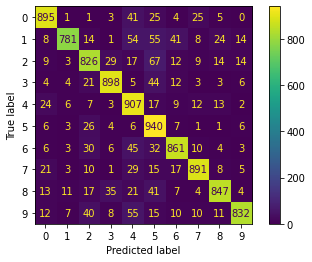

In [15]:
cm = confusion_matrix(y_test, predicted_classes)
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

## Reflection on Confusion Matrix
The matrixes of the default, 15 epoch, and 15 epoch 200 batch models were all very similar. However, the orginal setup had the best looking matrix upon a closer look. However, this is not linear with the accuracy scores above. This is because accuracy scores can not show the correct predictons for each label, thus a model can have worse accuracy but show better trends in a matrix.

# Create and Evaluate CNN
Next, we create an Convolutional Neural Network (CNN) Model.  Similar to the DNN model, you should calculate the steps_per_epoch below.  

As with the DNN model above, adjust the hyperparameters and data augmentation to try to achieve the best possible accuracy.  You can also try uncommenting the lines below to add some layers to the model to see if that has an effect on training time or accuracy.  Capture all your experiments in a table below.  

In [16]:
%%time
cnn_epochs = 5
cnn_batch_size = 64
steps_per_epoch = 60000 / 64

# TODO Calculate steps_per_epoch


cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
#cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history_cnn = cnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  epochs=cnn_epochs, steps_per_epoch=steps_per_epoch)


Epoch 1/5


2023-02-06 19:34:07.978089: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


937/937 [==============================] - 10s 9ms/step - loss: 0.8188 - accuracy: 0.7500
Epoch 2/5
937/937 [==============================] - 8s 9ms/step - loss: 0.3810 - accuracy: 0.8829
Epoch 3/5
937/937 [==============================] - 8s 9ms/step - loss: 0.3019 - accuracy: 0.9079
Epoch 4/5
937/937 [==============================] - 8s 9ms/step - loss: 0.2551 - accuracy: 0.9230
Epoch 5/5
937/937 [==============================] - 8s 9ms/step - loss: 0.2242 - accuracy: 0.9314
CPU times: user 1min 4s, sys: 4.79 s, total: 1min 9s
Wall time: 43.4 s


313/313 [==============================] - 1s 2ms/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 flatten_1 (Flatten)         (None, 9216)              0         
                                                                 
 dense_3 (Dense)             (None, 128)               1179776   
                                                                 
 dense_4 (Dense)             (None, 10)                1290      

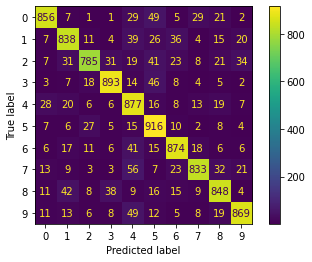

In [17]:
predicted_probabilities = cnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

acc = 100. * accuracy_score(y_test, predicted_classes)
cm = confusion_matrix(y_test, predicted_classes)
cnn_model.summary()

print("Accuracy: {:.2f}%".format(acc))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

Epoch 1/15
937/937 [==============================] - 8s 9ms/step - loss: 0.7621 - accuracy: 0.7627
Epoch 2/15
937/937 [==============================] - 8s 9ms/step - loss: 0.3702 - accuracy: 0.8868
Epoch 3/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2963 - accuracy: 0.9098
Epoch 4/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2514 - accuracy: 0.9230
Epoch 5/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2320 - accuracy: 0.9270
Epoch 6/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2063 - accuracy: 0.9365
Epoch 7/15
937/937 [==============================] - 8s 9ms/step - loss: 0.1875 - accuracy: 0.9443
Epoch 8/15
937/937 [==============================] - 8s 9ms/step - loss: 0.1664 - accuracy: 0.9487
Epoch 9/15
937/937 [==============================] - 8s 9ms/step - loss: 0.1581 - accuracy: 0.9517
Epoch 10/15
937/937 [==============================] - 8s 9ms/step - loss: 0.1475 - accuracy: 0.9551

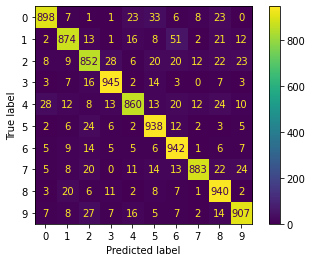

CPU times: user 3min 12s, sys: 13.1 s, total: 3min 25s
Wall time: 2min 6s


In [18]:
%%time
cnn_epochs = 15
cnn_batch_size = 64
steps_per_epoch = 60000 / 64

# TODO Calculate steps_per_epoch


cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
#cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history_cnn = cnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  epochs=cnn_epochs, steps_per_epoch=steps_per_epoch)
predicted_probabilities = cnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

acc = 100. * accuracy_score(y_test, predicted_classes)
cm = confusion_matrix(y_test, predicted_classes)
cnn_model.summary()

print("Accuracy: {:.2f}%".format(acc))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

Epoch 1/5
313/313 [==============================] - 0s 1ms/step
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 conv2d_5 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 9216)              0         
                                                                 
 dense_7 (Dense)             (None, 128)               1179776   
                                                                 
 dense_8 (Dense)             (None, 10)                

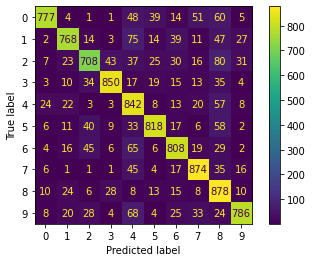

CPU times: user 27 s, sys: 2.11 s, total: 29.1 s
Wall time: 18.2 s


In [19]:
%%time
cnn_epochs = 5
cnn_batch_size = 200
steps_per_epoch = 60000 / 20

# TODO Calculate steps_per_epoch


cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
#cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history_cnn = cnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  epochs=cnn_epochs, steps_per_epoch=steps_per_epoch)
predicted_probabilities = cnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

acc = 100. * accuracy_score(y_test, predicted_classes)
cm = confusion_matrix(y_test, predicted_classes)
cnn_model.summary()

print("Accuracy: {:.2f}%".format(acc))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

Epoch 1/15
937/937 [==============================] - 9s 9ms/step - loss: 0.8975 - accuracy: 0.7230
Epoch 2/15
937/937 [==============================] - 9s 9ms/step - loss: 0.4210 - accuracy: 0.8689
Epoch 3/15
937/937 [==============================] - 8s 9ms/step - loss: 0.3345 - accuracy: 0.8976
Epoch 4/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2853 - accuracy: 0.9105
Epoch 5/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2408 - accuracy: 0.9248
Epoch 6/15
937/937 [==============================] - 8s 9ms/step - loss: 0.2202 - accuracy: 0.9327
Epoch 7/15
937/937 [==============================] - 8s 9ms/step - loss: 0.1948 - accuracy: 0.9405
Epoch 8/15
937/937 [==============================] - 8s 9ms/step - loss: 0.1746 - accuracy: 0.9470
Epoch 9/15
937/937 [==============================] - 8s 9ms/step - loss: 0.1598 - accuracy: 0.9520
Epoch 10/15
937/937 [==============================] - 8s 9ms/step - loss: 0.1477 - accuracy: 0.9549

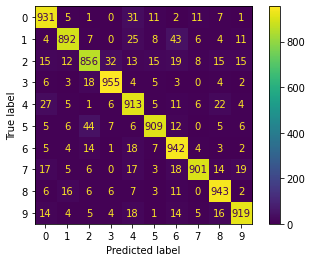

CPU times: user 3min 13s, sys: 13.7 s, total: 3min 26s
Wall time: 2min 7s


In [20]:
%%time
cnn_epochs = 15
cnn_batch_size = 64
steps_per_epoch = 60000 / 64

# TODO Calculate steps_per_epoch


cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history_cnn = cnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  epochs=cnn_epochs, steps_per_epoch=steps_per_epoch)
predicted_probabilities = cnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

acc = 100. * accuracy_score(y_test, predicted_classes)
cm = confusion_matrix(y_test, predicted_classes)
cnn_model.summary()

print("Accuracy: {:.2f}%".format(acc))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

In [ ]:
%%time
cnn_epochs = 15
cnn_batch_size = 64
steps_per_epoch = 60000 / 64

# TODO Calculate steps_per_epoch


cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history_cnn = cnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  epochs=cnn_epochs, steps_per_epoch=steps_per_epoch)
predicted_probabilities = cnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

acc = 100. * accuracy_score(y_test, predicted_classes)
cm = confusion_matrix(y_test, predicted_classes)
cnn_model.summary()

print("Accuracy: {:.2f}%".format(acc))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

Epoch 1/15
937/937 [==============================] - 9s 9ms/step - loss: 1.1502 - accuracy: 0.6251
Epoch 2/15
937/937 [==============================] - 8s 9ms/step - loss: 0.6273 - accuracy: 0.8049
Epoch 3/15
937/937 [==============================] - 8s 9ms/step - loss: 0.5103 - accuracy: 0.8405
Epoch 4/15
937/937 [==============================] - 8s 9ms/step - loss: 0.4458 - accuracy: 0.8612
Epoch 5/15
937/937 [==============================] - 8s 9ms/step - loss: 0.4060 - accuracy: 0.8749
Epoch 6/15
937/937 [==============================] - 8s 9ms/step - loss: 0.3607 - accuracy: 0.8908
Epoch 7/15
567/937 [=================>............] - ETA: 3s - loss: 0.3306 - accuracy: 0.8970

In [ ]:
%%time
cnn_epochs = 15
cnn_batch_size = 64
steps_per_epoch = 60000 / 64

# TODO Calculate steps_per_epoch


cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
#cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history_cnn = cnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  epochs=cnn_epochs, steps_per_epoch=steps_per_epoch)
predicted_probabilities = cnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

acc = 100. * accuracy_score(y_test, predicted_classes)
cm = confusion_matrix(y_test, predicted_classes)
cnn_model.summary()

print("Accuracy: {:.2f}%".format(acc))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

In [ ]:
%%time
cnn_epochs = 35
cnn_batch_size = 64
steps_per_epoch = 60000 / 64

# TODO Calculate steps_per_epoch


cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history_cnn = cnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  epochs=cnn_epochs, steps_per_epoch=steps_per_epoch)
predicted_probabilities = cnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

acc = 100. * accuracy_score(y_test, predicted_classes)
cm = confusion_matrix(y_test, predicted_classes)
cnn_model.summary()

print("Accuracy: {:.2f}%".format(acc))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

In [ ]:
%%time
cnn_epochs = 45
cnn_batch_size = 64
steps_per_epoch = 60000 / 64

# TODO Calculate steps_per_epoch


cnn_model = Sequential()
cnn_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dense(128, activation='relu'))
#cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(num_classes, activation='softmax'))

cnn_model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(),
              metrics=['accuracy'])
history_cnn = cnn_model.fit(datagen.flow(x_train,training_labels,shuffle=True),
                                  epochs=cnn_epochs, steps_per_epoch=steps_per_epoch)
predicted_probabilities = cnn_model.predict(x_test)
predicted_classes = np.argmax(predicted_probabilities, axis=1)

acc = 100. * accuracy_score(y_test, predicted_classes)
cm = confusion_matrix(y_test, predicted_classes)
cnn_model.summary()

print("Accuracy: {:.2f}%".format(acc))
cmp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1,2,3,4,5,6,7,8,9])
cmp.plot()
plt.show()

## CNN Results

| Model Name  | Activation | # Params | # Epochs | Batch Size | Dropout | Zoom | Train Acc | Test Acc | Tr. Time w/GPU |
| ----------- | --------- | -------- | -------- | ---------- | -------- | ---- |--------- | -------- | -------------- |
|Default| relu | 1,199,882 | 5 | 64 | NA | 0.01 | 93.46 | 85.82 | 0:42|
| +10 Epochs | relu | 1,199,882 | 15 | 64 |NA | 0.01 |97.67 | 91.33 |2:07|
| 200 Batch | relu | 1,199,882 | 5 | 200 | NA | 0.01 | 82.54 | 80.07 | 0:18|
|+10 Epoch, dropout | relu | 1,199,822 | 15 | 64| 0.25 |0.01| 97.59 |92.23| 2:08|
|+10 Epoch, 2x dropout,| relu | 1,199,882| 15| 64| .75| 0.01| 93.93 |90.4| 2:06|
|+10 Epoch, 2x dropout, +dense| relu | 1,199,882| 15| 64| .75| 0.01| 96.08 | 91.83 |2:06|
|+30 Epoch + droupout| relu| 1,199,822| 35|64|0.25|0.01| 99.69| 93.78 |4:54|
|+40 Epoch + droupout| relu| 1,199,822| 45|64|0.25|0.05| 99.51| 94.51 |6:24|

Identify the "best" confusion matrix for your CNN models:

Unlike the previous dnn model, the cnn matrixes show linearity with accuracy, thus the +10 epoch dropout model has the best matrix.

In this cell, answer the following questions 

1. Which model (CNN or DNN) achieved the best test accuracy, why?
Hint: it is possible to achieve better than 95% accuracy on the test set!

The CNN achived the best accuracy of 93.78% due to its lower overfitting. The DNN would overfit even with varying droppout.

2. Which model trained faster?  On what hardware (GPU/CPU only)?  Why might this be happening?

The DNN model trainned faster. This is because DNNs have more one to one neuron layer while CNNs have more fully connected layers, layers that take longer to compute.

3. Which model was larger (had the most parameters)?  How many parameters did each model have?  Is the number of parameters related to the time it takes to train the model?  

Each model had the same number of perameters....... Something is wrong, come back to this.

4. Based on your confusion matrices, which class was the most difficult to be accurate?  Was it consistently difficult among different models?  How can you use the results from the confusion matrix to inform how you would test the mobile app for accuracy?

Class 2 is the hardest to calssify based on the confusion matrixes. Although the DNN model had trouble with more than just class 2, it still had the most trouble with class 2. By targeting the weak labels from the matrix, one can apply special focus to that label to ensure its accuracy.


5. What affect did data augmentation have on the CNN and DNN models?  

Increasing any data augmentation resulted in lower testing and validation in both. Removing data augmentation increased overfitting in both models.

6. What did you notice when you deployed the models on the Android device?  Were the accuracy differences between the models noticeable?  

The accuracy in the app was much lower. This is due to the images being so low resolution. When we drawing the characters, the images get shrinked, so anything that is drawn small is very hard to classify.



## Converting the model to TFLite for exporting to Android/iOS

In [ ]:
# TODO make sure you are exporting the right model here!
converter = tf.lite.TFLiteConverter.from_keras_model(cnn_model)
tflite_float_model = converter.convert()

# Show model size in KBs.
float_model_size = len(tflite_float_model) / 1024
print('Float model size = %dKBs.' % float_model_size)

Since this model will be on a mobile device, we want it to small and fast.  **Quantization** is an approach used to shrink ML models. In the following code, we use 8-bit numbers to approximate our 32-bit weights, which shrinks the model size by a factor of 4.

In [ ]:
# Re-convert the model to TF Lite using quantization.
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

# Show model size in KBs.
quantized_model_size = len(tflite_quantized_model) / 1024
print('Quantized model size = %dKBs,' % quantized_model_size)
print('which is about %d%% of the float model size.'\
      % (quantized_model_size * 100 / float_model_size))

Next, we download the TFLite model to be used in the mobile device!

In [ ]:
# Save the quantized model to file to the Downloads directory
f = open('kmnist1.tflite', "wb")
f.write(tflite_quantized_model)
f.close()

print('`kmnist.tflite` has been downloaded')

This notebook was originally created by RJ Nowling and modified by Derek Riley